In [17]:
import sys
sys.path.append('..')
from network import *
from utils import *

import torch
import matplotlib.pyplot as plt

In [19]:
z_min=0
z_max=1
use_layernorm = False
MM = 1024
NN = 1024
num_modes = 512
num_feats = 32
cur_ds = 1

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

model = FullModel(
    w=MM,
    h=MM,
    num_feats=num_feats,
    x_mode=num_modes,
    y_mode=num_modes,
    z_min=z_min,
    z_max=z_max,
    ds_factor=cur_ds,
    use_layernorm=use_layernorm,
).to(device)
load_model_with_required_grad(model, "/nfshomes/mattchan/scratch/FPM_INR/trained_models/Thyroid.pth")

In [24]:
amp = []
phase = []
for color in torch.LongTensor([0, 1, 2]):
    img_ampli, img_phase = model(color.unsqueeze(0))
    amp.append(img_ampli[0])
    phase.append(img_phase[0])
amp = torch.stack(amp).detach().cpu().numpy()
phase = torch.stack(phase).detach().cpu().numpy()

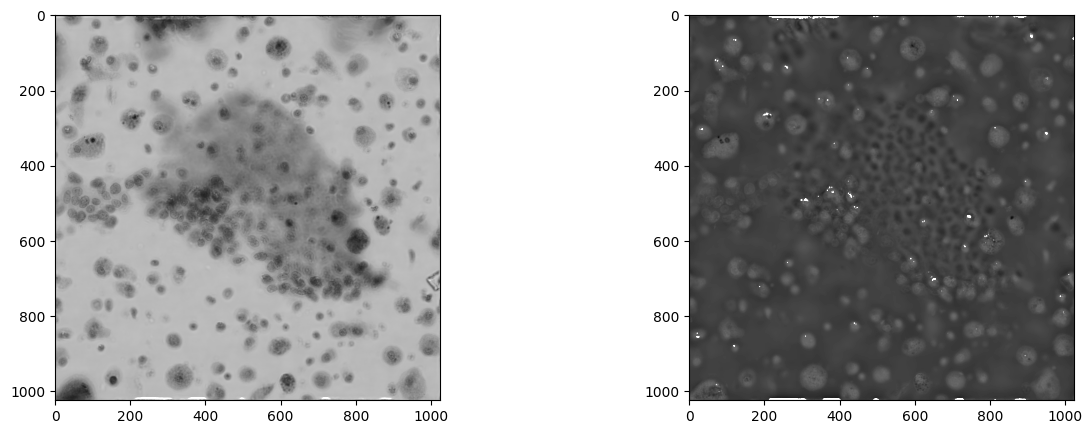

In [42]:
fig, axs = plt.subplots(1, 2, figsize=(15, 5))
axs[0].imshow(amp[2], cmap='gray', vmin=0, vmax=0.16)
axs[1].imshow(phase[2], cmap='gray', vmax=4)


In [ ]:
amplitude = (img_ampli[0].float()).cpu().detach().numpy()
phase = (img_phase[0].float()).cpu().detach().numpy()

fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(20, 10))

im = axs[0].imshow(amplitude, cmap="gray")
axs[0].axis("image")
axs[0].set_title("Reconstructed amplitude")
divider = make_axes_locatable(axs[0])
cax = divider.append_axes("right", size="5%", pad=0.05)
fig.colorbar(im, cax=cax, orientation="vertical")

im = axs[1].imshow(phase, cmap="gray")  # - phase.mean()
axs[1].axis("image")
axs[1].set_title("Reconstructed phase")
divider = make_axes_locatable(axs[1])
cax = divider.append_axes("right", size="5%", pad=0.05)
fig.colorbar(im, cax=cax, orientation="vertical")

plt.savefig(f"{vis_dir}/e_{epoch}.png")

In [1]:
import imageio
import numpy as np

In [2]:
imageio.help(".mp4")

FFMPEG - Many video formats and cameras (via ffmpeg)

    Read/Write ImageResources using FFMPEG.

    See :mod:`imageio.plugins.ffmpeg`



In [10]:
import torch
dzs = torch.FloatTensor([0, 1, 2])
print(dzs)
for dz in dzs:
    print(dz.shape)
dz = torch.FloatTensor([0])
print(dz.shape)

tensor([0., 1., 2.])
torch.Size([])
torch.Size([])
torch.Size([])
torch.Size([1])


In [9]:
import numpy as np
a = np.random.randn(3, 1)
b = np.random.randn(1024,)
tmp = b[None,...].repeat(3, axis=0)
print(tmp.shape)
a*tmp


(3, 1024)


array([[-0.2355565 , -2.203602  ,  0.01434968, ..., -1.91867349,
        -0.14894449,  0.23358628],
       [-0.17424812, -1.63006974,  0.01061489, ..., -1.41929967,
        -0.11017866,  0.1727907 ],
       [-0.07978576, -0.74638598,  0.00486041, ..., -0.64987734,
        -0.05044926,  0.07911843]])

In [3]:
imgs = np.random.randn(100, 64, 64, 3)
imageio.mimwrite(
    "test.mp4", np.uint8(imgs * 255), fps=5, quality=8
)

In [1]:
import sys
sys.path.append('../')
from network import *
import os
import tqdm
import mat73
import scipy.io as sio
import imageio
import argparse
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable

import torch
import torch.nn.functional as F

Obtain raw measurements

In [ ]:
sample = "Siemens"
color = "r"
data_struct = sio.loadmat(f"../data/{sample}/{sample}_{color}.mat")
# data_struct = mat73.loadmat(f"../data/{sample}/{sample}_{color}_1024.mat")
print(data_struct.keys())
print(data_struct["I_low"].shape)

dict_keys(['__header__', '__version__', '__globals__', 'I_low', 'dpix_c', 'freqXY_calib', 'lambda', 'mag', 'na_cal', 'na_calib', 'na_rp_cal'])
(512, 512, 45)


In [8]:
print(data_struct["na_calib"].shape, data_struct["na_cal"])

(68, 2) 0.2559741092995169


In [10]:
print(data_struct["na_calib"][:, 0].shape)
print(data_struct["na_calib"][:, 1])

(68,)
[-0.18058504 -0.17717323 -0.17759097 -0.18123774 -0.12737151 -0.12767152
 -0.1277005  -0.12699763 -0.12916891 -0.12929394 -0.074525   -0.07302174
 -0.07458788 -0.07749474 -0.07499895 -0.07735602 -0.07701095 -0.07875707
 -0.02386079 -0.02339274 -0.02486689 -0.02508754 -0.02623375 -0.02485882
 -0.02734906 -0.0266368   0.02386079  0.02602608  0.02550867  0.02150274
  0.02013415  0.02574574  0.02382894  0.02347278  0.07928018  0.07634883
  0.07828909  0.07297887  0.07240603  0.07127512  0.07516835  0.07654984
  0.12707104  0.12782327  0.12602766  0.12702454  0.12476083  0.12810424
  0.1792878   0.17911552  0.17811446  0.17525874  0.20369951  0.24612957
  0.25005842  0.21319597  0.14678426  0.05907395 -0.0383646  -0.13547901
 -0.20525911 -0.24684227 -0.24934493 -0.21450463 -0.14988462 -0.05829227
  0.04123458  0.13520061]


dict_keys(['I_low', 'NA', 'Nled', 'dpix_c', 'freqXY_calib', 'freqXY_design', 'h', 'lambda', 'mag', 'na_cal', 'na_calib', 'na_design', 'na_rp_cal', 'na_rp_nom'])
3.45 10.0
[[ 0.08115279 -0.18058504]
 [ 0.03006236 -0.17717323]
 [-0.02221488 -0.17759097]
 [-0.07211809 -0.18123774]
 [ 0.13189706 -0.12737151]
 [ 0.08122224 -0.12767152]
 [ 0.0278664  -0.1277005 ]
 [-0.01968282 -0.12699763]
 [-0.07597629 -0.12916891]
 [-0.12269536 -0.12929394]
 [ 0.18263079 -0.074525  ]
 [ 0.12666233 -0.07302174]
 [ 0.07723801 -0.07458788]
 [ 0.02842153 -0.07749474]
 [-0.0235535  -0.07499895]
 [-0.07340812 -0.07735602]
 [-0.12341694 -0.07701095]
 [-0.17525395 -0.07875707]
 [ 0.17811446 -0.02386079]
 [ 0.12859523 -0.02339274]
 [ 0.07918106 -0.02486689]
 [ 0.02786254 -0.02508754]
 [-0.02362098 -0.02623375]
 [-0.07457647 -0.02485882]
 [-0.13079928 -0.02734906]
 [-0.17550397 -0.0266368 ]
 [ 0.17811446  0.02386079]
 [ 0.12968451  0.02602608]
 [ 0.0743567   0.02550867]
 [ 0.02517647  0.02150274]
 [-0.02048866  0.02

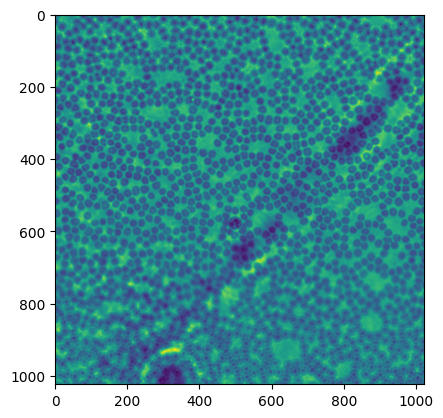

In [6]:
# Config params
sample = "BloodSmearTilt"
num_modes = 512
color = "g"
num_feats = 32
z_max = 20.0
z_min = -20.0
cur_ds = 1 # no downsampling
use_layernorm = False


data_struct = mat73.loadmat(f"../data/{sample}/{sample}_{color}.mat")
print(data_struct.keys())
print(data_struct["dpix_c"], data_struct["mag"])
print(data_struct["na_calib"], data_struct["na_cal"])

I = data_struct["I_low"].astype("float32")
print("Original I shape:", I.shape)

# Select ROI
I = I[0:int(num_modes*2), 0:int(num_modes*2), :] 

# Raw measurement sidelength
M = I.shape[0]
N = I.shape[1]
ID_len = I.shape[2]

# NAx NAy
NAs = data_struct["na_calib"].astype("float32")
NAx = NAs[:, 0]
NAy = NAs[:, 1]

# LED central wavelength
if color == "r":
    wavelength = 0.632  # um
elif color == "g":
    wavelength = 0.5126  # um
elif color == "b":
    wavelength = 0.471  # um

# Distance between two adjacent LEDs (unit: um)
D_led = 4000
# free-space k-vector
k0 = 2 * np.pi / wavelength
# Objective lens magnification
mag = data_struct["mag"].astype("float32")
# Camera pixel pitch (unit: um)
pixel_size = data_struct["dpix_c"].astype("float32")
# pixel size at image plane (unit: um)
D_pixel = pixel_size / mag
# Objective lens NA
NA = data_struct["na_cal"].astype("float32")
# Maximum k-value
kmax = NA * k0

# Calculate upsampling ratio
MAGimg = 2
# Upsampled pixel count
MM = int(M * MAGimg)
NN = int(N * MAGimg)


# Define spatial frequency coordinates
Fxx1, Fyy1 = np.meshgrid(np.arange(-NN / 2, NN / 2), np.arange(-MM / 2, MM / 2))
Fxx1 = Fxx1[0, :] / (N * D_pixel) * (2 * np.pi)
Fyy1 = Fyy1[:, 0] / (M * D_pixel) * (2 * np.pi)

# Calculate illumination NA
u = -NAx
v = -NAy
NAillu = np.sqrt(u**2 + v**2)
order = np.argsort(NAillu)
u = u[order]
v = v[order]

# NA shift in pixel from different LED illuminations
ledpos_true = np.zeros((ID_len, 2), dtype=int)
count = 0
for idx in range(ID_len):
    Fx1_temp = np.abs(Fxx1 - k0 * u[idx])
    ledpos_true[count, 0] = np.argmin(Fx1_temp)
    Fy1_temp = np.abs(Fyy1 - k0 * v[idx])
    ledpos_true[count, 1] = np.argmin(Fy1_temp)
    count += 1
# Raw measurements
Isum = I[:, :, order] / np.max(I)
print("Final shape:", Isum.shape)
plt.imshow(Isum[:, :, 4])
plt.show()

In [38]:
# Why 2x upsampling and where do we downsample back down?
print(MM, NN)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = FullModel(
    w=MM,
    h=MM,
    num_feats=num_feats,
    x_mode=num_modes,
    y_mode=num_modes,
    z_min=z_min,
    z_max=z_max,
    ds_factor=cur_ds,
    use_layernorm=use_layernorm,
).to(device)

2048 2048


In [100]:
x_dim = 2048 // cur_ds
y_dim = 2048 // cur_ds
x_max = num_modes
y_max = num_modes

# Space from 0 to 1
half_dx = 0.5 / x_dim
xs = torch.linspace(half_dx, 1 - half_dx, x_dim)
xv, yv = torch.meshgrid([xs, xs], indexing="ij")
xy = torch.stack((yv.flatten(), xv.flatten())).t()

# Convert back to 0 to 512 space
xs = xy * torch.tensor([x_max, x_max], device=xs.device).float()
indices = xs.long()

x0 = nn.Parameter(
    indices[:, 0].clamp(min=0, max=x_max - 1),
    requires_grad=False,
)
y0 = nn.Parameter(
    indices[:, 1].clamp(min=0, max=y_max - 1),
    requires_grad=False,
)
x1 = nn.Parameter(
    (x0 + 1).clamp(max=x_max - 1), requires_grad=False
)
y1 = nn.Parameter(
    (y0 + 1).clamp(max=y_max - 1), requires_grad=False
)
lerp_weights = nn.Parameter(xs - indices.float(), requires_grad=False)
print(xs[0], xs[1], xs[2048])
print(lerp_weights[4])

tensor([0.1250, 0.1250]) tensor([0.3750, 0.1250]) tensor([0.1250, 0.3750])
tensor([0.1250, 0.1250])


In [101]:
# 2d matrix is 512x512x32 shaped
data = nn.Parameter(
    2e-4 * torch.randn((num_modes, num_modes, num_feats)),
    requires_grad=True,
)
# Bilinear interpolation across the entire image (sampled at 2048x2048)
xy_feat = (
    data[y0, x0]
    * (1.0 - lerp_weights[:, 0:1])
    * (1.0 - lerp_weights[:, 1:2])
    + data[y0, x1]
    * lerp_weights[:, 0:1]
    * (1.0 - lerp_weights[:, 1:2])
    + data[y1, x0]
    * (1.0 - lerp_weights[:, 0:1])
    * lerp_weights[:, 1:2]
    + data[y1, x1]
    * lerp_weights[:, 0:1]
    * lerp_weights[:, 1:2]
)
print(xy_feat.shape)

torch.Size([4194304, 32])


how does optimization of the z-depth work?
- measurements are simply a subspectrum of the super-resolved image (and aren't a function of depth)
- 